In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
from beamforming import curvedWaveFront, timeDomain
from kam11 import thermister, context, rayModeling
from atpy import bellhop, arrivals
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
import os
from collections import OrderedDict

In [2]:
# Array tilt angle
phi=0

timeOfInterest='2011 J184 03:51'
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M')
numTheta=300
thetaRange=(-8,8)
bellhopFilesDir = '/Users/edwardlrichards/cir_processing/bellhopFiles/beamforming'
bellhopFigDir = '/Users/edwardlrichards/cir_processing/bellhopFiles/beamforming/figs'
# simulated sampling axis
winStart=1.956
winEnd=1.965
fs=1e6
#Number of beamforming times
numWindow=300
beamformingStart=1.959
beamformingEnd=1.964

#Array tilt
tilt=5

In [3]:
%autoreload
rd=context.VLA1(tof)
pos=rd.phonePosition(tiltAngle=2)

In [4]:
ssp = thermister.getSoundSpeed(tof)
arr=rayModeling.getBellhopArrivals(tof,\
                bellhopFilesDir=bellhopFilesDir, tiltAngle=tilt)

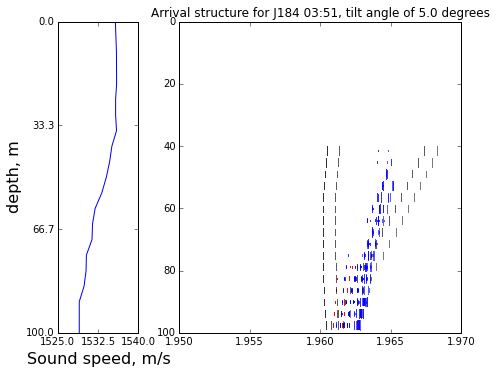

In [5]:
title='Arrival structure for %s, tilt angle of %0.1f degrees'\
    %(tof.strftime('J%j %H:%M'),tilt)
figName=tof.strftime('J%j_%H_%M_Arrivals')
fig=bellhop.plotArrivalSpark(title, ssp, arr,\
    figDir=bellhopFigDir, figName=figName)

In [6]:
#Create a time series with a common amplitude reference
arr.magnitudeOffset(0)
simData=arr.sampleArrivals(fs,winStart,winEnd)

In [7]:
thetaTest=np.r_[thetaRange[0]:thetaRange[1]:1j*numTheta]
rd=pos['depth']
dr=pos['range']
testDelay=curvedWaveFront.getDelays(thetaTest, ssp, rd,\
                                    z0=rd[1], dr=dr)
centerTime=np.r_[beamformingStart:beamformingEnd:1j*numWindow]
beams=timeDomain.timeBeamformer(simData, centerTime, testDelay)

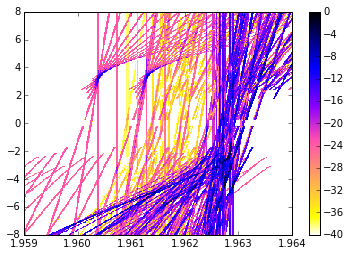

In [8]:
lookDB=20*np.log10(np.abs(np.array(beams))+np.spacing(1))
lookDB-=np.max(lookDB)
X,Y=np.meshgrid(centerTime,thetaTest)
fig,ax=plt.subplots()
pc=ax.pcolormesh(X,Y,lookDB.T,vmin=-40,vmax=0,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)

ax.set_ylim(-8,8)
ax.set_xlim(1.959,1.963)
# _=cb.set_ticks([-40,-30-20,-10,0])
_=ax.set_xlim(beamformingStart,beamformingEnd)
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)

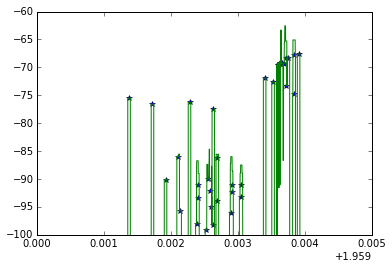

In [9]:
simDB=20*np.log10(np.abs(np.array(simData))+np.spacing(1))
channelOfInterest=0
ampDB=arr.magnitude[channelOfInterest]
_=plt.plot(ampDB.index,ampDB,'*')
_=plt.plot(simData.index,simDB[:,channelOfInterest])
_=plt.xlim(beamformingStart,beamformingEnd)
_=plt.ylim(-100,-60)

In [10]:
bellA.filterArrivals(numTopBounces=1)
ct=arr.angles[0].index[1]
bellA.filterArrivals()
beamformer=timeDomain.ShiftAndAdd(simData)
samplesAtTime=beamformer.resampler(ct+testDelay)
X,Y=np.meshgrid(thetaTest,rd)
samplesDB=20*np.log10(np.abs(np.array(samplesAtTime)) + np.spacing(1))
_=plt.pcolormesh(X,Y,samplesDB.T,\
                 vmin=-120,vmax=-60,\
                 cmap=plt.cm.gnuplot2_r)
_=plt.colorbar()
_=plt.ylim(100,40)
# _=plt.xlim(3,7)
_=plt.title('Arrival Amplitudes at %0.4f s'%ct)

NameError: name 'bellA' is not defined

In [ ]:
bellA.filterArrivals(numTopBounces=1, arrivalMagnitude=-90)

In [ ]:
#Compare modeled wave front curvature with bellhop, focusing
#on surface bounces
ax=plt.axes()
# plot bellhop prediction
for delay,r in zip(arr.delay,rd):
    _=ax.plot(delay, r*np.ones(delay.shape), 'b.', label='bellhop')
    
# curved wave fronts
curvedDelay=curvedWaveFront.getDelays(arr.angles[0], ssp, rd, rd[1])
for delay,r in zip(curvedDelay.T.iterrows(), rd):
    _=ax.plot(delay[1]+arr.delay[0], r*np.ones(delay[1].shape),\
              'ro', label='snells',fillstyle=u'none')

_=ax.set_ylim(100,40)
_=ax.set_xlim(1.956,1.965)
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
# plot only unique legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
_=ax.legend(by_label.values(), by_label.keys(),loc=3)
_=ax.set_xlabel('delay, s')
_=ax.set_ylabel('depth, m')
_=plt.title('Comparison of bellhop output and curved plane wave')
# plt.savefig('/Users/edwardlrichards/ipythonNotebooks/KAM 11 enviornment/curvedWaveFronts/figures/surfaceWaveFronts')